# Healthcare Claims Fraud Detection - Model Training & Experiments

## Overview
This notebook focuses on training and evaluating machine learning models for healthcare fraud detection. We'll experiment with multiple algorithms, perform hyperparameter tuning, and select the best performing model based on comprehensive evaluation metrics.

## Objectives
- Load processed data from feature engineering phase
- Train and evaluate multiple ML algorithms
- Perform hyperparameter tuning for optimal performance
- Compare models using comprehensive metrics
- Select and save the best performing model
- Generate detailed performance reports and visualizations

## Model Selection Strategy
1. **Ensemble Methods**: Random Forest, XGBoost, CatBoost
2. **Linear Models**: Logistic Regression, Ridge Classifier
3. **Tree-Based**: Decision Tree, Extra Trees
4. **Advanced**: Neural Networks, SVM
5. **Focus on CatBoost**: Based on superior performance for categorical data

## Evaluation Metrics
- **Primary**: ROC-AUC (handles class imbalance well)
- **Secondary**: Precision, Recall, F1-Score
- **Business**: False Positive Rate, False Negative Rate
- **Comprehensive**: Classification Report, Confusion Matrix

---

In [24]:
# 📚 Comprehensive Model Training Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
from datetime import datetime

# Machine Learning Core
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Evaluation Metrics
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve, 
                           average_precision_score, confusion_matrix, f1_score, 
                           precision_score, recall_score, accuracy_score, roc_curve)

# Machine Learning Algorithms
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                             ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Advanced Algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Configure environment
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [15, 10]

# Ensure directories exist
os.makedirs('../models', exist_ok=True)
os.makedirs('../plots', exist_ok=True)

print("🤖 Machine Learning libraries imported successfully!")
print("🎯 Ready for comprehensive model training and evaluation")
print(f"📅 Training session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🤖 Machine Learning libraries imported successfully!
🎯 Ready for comprehensive model training and evaluation
📅 Training session started: 2025-08-02 14:58:25


In [25]:
# 🔄 Load Processed Data from Feature Engineering Phase
print("🔄 Loading processed dataset from feature engineering phase...")

try:
    df_cleaned = pd.read_csv('../data/health_claims_cleaned.csv')
    print(f"✅ Data loaded successfully!")
    
    # Comprehensive data validation
    print(f"\n📊 Dataset Overview:")
    print(f"  • Shape: {df_cleaned.shape}")
    print(f"  • Memory usage: {df_cleaned.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"  • Missing values: {df_cleaned.isnull().sum().sum()}")
    print(f"  • Duplicate rows: {df_cleaned.duplicated().sum()}")
    
    # Target variable analysis
    if 'Is_Fraudulent' in df_cleaned.columns:
        target_dist = df_cleaned['Is_Fraudulent'].value_counts()
        fraud_rate = df_cleaned['Is_Fraudulent'].mean() * 100
        print(f"\n🎯 Target Variable Analysis:")
        print(f"  • Fraud rate: {fraud_rate:.1f}%")
        print(f"  • Class distribution: {target_dist.to_dict()}")
        print(f"  • Class imbalance ratio: {target_dist[0]/target_dist[1]:.1f}:1")
    
    # Feature analysis
    numerical_features = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df_cleaned.select_dtypes(include=['object']).columns.tolist()
    
    if 'Is_Fraudulent' in numerical_features:
        numerical_features.remove('Is_Fraudulent')
    
    print(f"\n🔢 Feature Breakdown:")
    print(f"  • Numerical features: {len(numerical_features)}")
    print(f"  • Categorical features: {len(categorical_features)}")
    print(f"  • Total features for training: {len(numerical_features) + len(categorical_features)}")
    
    # Data quality checks
    print(f"\n🔍 Data Quality Assessment:")
    infinite_values = np.isinf(df_cleaned.select_dtypes(include=[np.number])).sum().sum()
    print(f"  • Infinite values: {infinite_values}")
    
    if infinite_values > 0:
        print("⚠️ Warning: Found infinite values in dataset")
    
    print(f"  • Data types: {dict(df_cleaned.dtypes.value_counts())}")
    
except FileNotFoundError:
    print("❌ Error: Processed data file not found!")
    print("Please run 02_feature_engineering.ipynb first to generate the processed dataset.")
    raise
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

🔄 Loading processed dataset from feature engineering phase...
✅ Data loaded successfully!

📊 Dataset Overview:
  • Shape: (20100, 136)
  • Memory usage: 20.86 MB
  • Missing values: 0
  • Duplicate rows: 28

🎯 Target Variable Analysis:
  • Fraud rate: 24.9%
  • Class distribution: {0: 15089, 1: 5011}
  • Class imbalance ratio: 3.0:1

🔢 Feature Breakdown:
  • Numerical features: 135
  • Categorical features: 0
  • Total features for training: 135

🔍 Data Quality Assessment:
  • Infinite values: 0
  • Data types: {dtype('float64'): 129, dtype('int64'): 7}
✅ Data loaded successfully!

📊 Dataset Overview:
  • Shape: (20100, 136)
  • Memory usage: 20.86 MB
  • Missing values: 0
  • Duplicate rows: 28

🎯 Target Variable Analysis:
  • Fraud rate: 24.9%
  • Class distribution: {0: 15089, 1: 5011}
  • Class imbalance ratio: 3.0:1

🔢 Feature Breakdown:
  • Numerical features: 135
  • Categorical features: 0
  • Total features for training: 135

🔍 Data Quality Assessment:
  • Infinite values: 0
 

In [26]:
df_cleaned.head()  # Display the first few rows of the cleaned DataFrame

,Patient_State,Provider_Specialty,Diagnosis_Code,Procedure_Code,Number_of_Previous_Claims_Patient,Number_of_Previous_Claims_Provider,Is_Fraudulent,Claim_Service_Difference,Cost_Per_Procedure,Log_Claim_Amount,...,Patient_Age_83.0,Patient_Age_84.0,Patient_Age_85.0,Patient_Age_86.0,Patient_Age_87.0,Patient_Age_88.0,Patient_Age_89.0,Patient_Age_90.0,Provider_Patient_Distance_Category_Low,Provider_Patient_Distance_Category_Medium
0,1.261974,1.659610,0.151646,0.140610,-0.01728,0.901833,0,0.036400,-0.430402,-0.786060,...,-0.109465,-0.109232,-0.110393,-0.104226,-0.107825,-0.110853,-0.105679,-0.103737,-0.582942,-0.990887
1,-0.635083,1.659610,2.472967,0.826761,-0.01728,-0.608247,1,-1.635309,1.582017,0.748881,...,-0.109465,-0.109232,-0.110393,-0.104226,-0.107825,-0.110853,-0.105679,-0.103737,1.715437,-0.990887
2,0.904174,-0.610372,-0.427573,-2.627671,-0.01728,-1.212278,0,-0.115574,2.102428,0.500575,...,-0.109465,-0.109232,-0.110393,-0.104226,-0.107825,-0.110853,-0.105679,9.639774,-0.582942,1.009197
3,1.141892,-0.567247,-0.511650,0.135826,-0.01728,-1.212278,1,-1.521329,-0.598905,-0.553009,...,-0.109465,-0.109232,-0.110393,-0.104226,-0.107825,-0.110853,-0.105679,-0.103737,-0.582942,1.009197
4,0.904174,-0.567247,-0.445633,0.135826,-0.01728,0.750825,0,-0.343534,0.393473,0.861687,...,-0.109465,-0.109232,-0.110393,-0.104226,-0.107825,-0.110853,-0.105679,-0.103737,-0.582942,-0.990887


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve, 
                           average_precision_score, confusion_matrix, f1_score, 
                           precision_score, recall_score, accuracy_score)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                             ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print("🔄 Starting optimized fraud detection model training pipeline...")

# Prepare features and target
X = df_cleaned.drop(columns=['Is_Fraudulent'])
y = df_cleaned['Is_Fraudulent']
print(f"📊 Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"📈 Class distribution: {y.value_counts().to_dict()}")

# Split data: 80% train, 20% test (stratify to maintain target distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
print(f"✅ Train/Test split: {X_train.shape[0]}/{X_test.shape[0]} samples")

# Optimized hyperparameter grids for top-performing models only
models_params = {
    # TOP TIER - Most effective for fraud detection
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.1, 0.15],
            'model__max_depth': [5, 7],
            'model__subsample': [0.8, 0.9],
            'model__colsample_bytree': [0.8, 0.9]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [15, 20],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(random_state=42, verbose=0),
        'params': {
            'model__iterations': [100, 200],
            'model__learning_rate': [0.1, 0.15],
            'model__depth': [5, 7]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'model__C': [1, 10, 100],
            'model__penalty': ['l2'],
            'model__solver': ['liblinear', 'lbfgs']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.1, 0.15],
            'model__max_depth': [5, 7],
            'model__subsample': [0.8, 0.9]
        }
    }
    
    # COMMENTED OUT - Less effective or slower models for fraud detection
    # 'AdaBoost': {
    #     'model': AdaBoostClassifier(random_state=42),
    #     'params': {
    #         'model__n_estimators': [50, 100, 200],
    #         'model__learning_rate': [0.5, 1.0, 1.5],
    #         'model__algorithm': ['SAMME', 'SAMME.R']
    #     }
    # },
    # 'SVC': {
    #     'model': SVC(random_state=42, probability=True),
    #     'params': {
    #         'model__C': [0.1, 1, 10, 100],
    #         'model__kernel': ['rbf', 'poly'],
    #         'model__gamma': ['scale', 'auto']
    #     }
    # },
    # 'KNeighbors': {
    #     'model': KNeighborsClassifier(n_jobs=-1),
    #     'params': {
    #         'model__n_neighbors': [3, 5, 7, 9, 11],
    #         'model__weights': ['uniform', 'distance'],
    #         'model__metric': ['euclidean', 'manhattan']
    #     }
    # },
    # 'DecisionTree': {
    #     'model': DecisionTreeClassifier(random_state=42),
    #     'params': {
    #         'model__max_depth': [5, 10, 15, 20, None],
    #         'model__min_samples_split': [2, 5, 10],
    #         'model__min_samples_leaf': [1, 2, 4],
    #         'model__criterion': ['gini', 'entropy']
    #     }
    # },
    # 'Bagging': {
    #     'model': BaggingClassifier(random_state=42, n_jobs=-1),
    #     'params': {
    #         'model__n_estimators': [10, 50, 100, 200],
    #         'model__max_samples': [0.5, 0.7, 1.0],
    #         'model__max_features': [0.5, 0.7, 1.0]
    #     }
    # },
    # 'GaussianNB': {
    #     'model': GaussianNB(),
    #     'params': {
    #         'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    #     }
    # },
    # 'LinearDiscriminant': {
    #     'model': LinearDiscriminantAnalysis(),
    #     'params': {
    #         'model__solver': ['svd', 'lsqr', 'eigen'],
    #         'model__shrinkage': [None, 'auto', 0.1, 0.5]
    #     }
    # },
    # 'QuadraticDiscriminant': {
    #     'model': QuadraticDiscriminantAnalysis(),
    #     'params': {
    #         'model__reg_param': [0.0, 0.1, 0.3, 0.5]
    #     }
    # }
}

# Optimized cross-validation strategy
cv_strategies = {
    'StratifiedKFold_5': StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
}


def calculate_comprehensive_metrics(y_true, y_pred, y_proba):
    """Calculate comprehensive performance metrics"""
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    metrics['avg_precision'] = average_precision_score(y_true, y_proba)
    
    # Confusion matrix derived metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    metrics['false_positive_rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0
    metrics['false_negative_rate'] = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    return metrics

def train_model_comprehensive(model_name, mp, cv_strategy='StratifiedKFold_5'):
    """Enhanced model training with comprehensive evaluation"""
    print(f"🚀 Training {model_name} with {cv_strategy}...")
    
    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', mp['model'])
    ])
    
    # GridSearchCV with specified CV strategy
    cv = cv_strategies[cv_strategy]
    grid = GridSearchCV(
        pipeline, 
        param_grid=mp['params'], 
        cv=cv, 
        scoring='roc_auc', 
        n_jobs=-1, 
        verbose=0
    )
    
    try:
        grid.fit(X_train, y_train)
        
        # Cross-validation scores
        cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train, 
                                  cv=cv, scoring='roc_auc', n_jobs=-1)
        
        # Evaluate on test set
        y_pred = grid.best_estimator_.predict(X_test)
        y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
        
        # Calculate comprehensive metrics
        metrics = calculate_comprehensive_metrics(y_test, y_pred, y_proba)
        
        # Add cross-validation metrics
        metrics['cv_mean_roc_auc'] = cv_scores.mean()
        metrics['cv_std_roc_auc'] = cv_scores.std()
        
        print(f"✅ {model_name} - ROC AUC: {metrics['roc_auc']:.4f} (CV: {metrics['cv_mean_roc_auc']:.4f}±{metrics['cv_std_roc_auc']:.4f})")
        
        result = {
            'Model': model_name,
            'CV_Strategy': cv_strategy,
            'Best_Params': grid.best_params_,
            'Best_Model': grid.best_estimator_,
            **metrics
        }
        
        return result
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        return None

# Train optimized set of models
print(f"📊 Training {len(models_params)} top-performing models for speed optimization...")
results = []
failed_models = []

for model_name, mp in models_params.items():
    try:
        result = train_model_comprehensive(model_name, mp, 'StratifiedKFold_5')
        if result:
            results.append(result)
    except Exception as e:
        print(f"❌ {model_name} failed completely: {str(e)}")
        failed_models.append(model_name)

# Create comprehensive results summary
if results:
    metrics_columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'avg_precision', 
                      'specificity', 'sensitivity', 'cv_mean_roc_auc', 'cv_std_roc_auc']
    
    results_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['Best_Model', 'Best_Params']} for r in results])
    results_df = results_df.sort_values(by='roc_auc', ascending=False)
    
    print("\n🏆 Optimized Model Performance Summary (Ranked by ROC AUC):")
    print("=" * 120)
    print(results_df[['Model', 'roc_auc', 'precision', 'recall', 'f1_score', 'cv_mean_roc_auc', 'cv_std_roc_auc']].round(4))
    
    print("\n📊 Detailed Performance Metrics:")
    print("=" * 120)
    detailed_metrics = results_df[['Model'] + metrics_columns].round(4)
    print(detailed_metrics)
    
    # Best model analysis
    best_model_name = results_df.iloc[0]['Model']
    best_result = next(r for r in results if r['Model'] == best_model_name)
    
    print(f"\n🥇 Best Model: {best_model_name}")
    print(f"📈 ROC AUC: {best_result['roc_auc']:.4f}")
    print(f"🎯 Precision: {best_result['precision']:.4f}")
    print(f"📊 Recall (Sensitivity): {best_result['recall']:.4f}")
    print(f"⚖️ F1-Score: {best_result['f1_score']:.4f}")
    print(f"🔍 Specificity: {best_result['specificity']:.4f}")
    print(f"📏 Average Precision: {best_result['avg_precision']:.4f}")
    print(f"🔄 CV ROC AUC: {best_result['cv_mean_roc_auc']:.4f} ± {best_result['cv_std_roc_auc']:.4f}")
    
    # Model comparison insights
    print(f"\n📈 Model Performance Insights:")
    print(f"• Best ROC AUC: {results_df['roc_auc'].max():.4f} ({results_df.iloc[0]['Model']})")
    print(f"• Best Precision: {results_df['precision'].max():.4f} ({results_df.loc[results_df['precision'].idxmax(), 'Model']})")
    print(f"• Best Recall: {results_df['recall'].max():.4f} ({results_df.loc[results_df['recall'].idxmax(), 'Model']})")
    print(f"• Best F1-Score: {results_df['f1_score'].max():.4f} ({results_df.loc[results_df['f1_score'].idxmax(), 'Model']})")
    print(f"• Most Stable (lowest CV std): {results_df.loc[results_df['cv_std_roc_auc'].idxmin(), 'Model']} (±{results_df['cv_std_roc_auc'].min():.4f})")
    
    if failed_models:
        print(f"\n⚠️ Failed Models: {', '.join(failed_models)}")
    
    print("\n🚀 Speed-optimized training completed successfully!")
    print(f"⚡ Training time reduced by focusing on top 5 models instead of 13")
    
    # Store results for further analysis
    comprehensive_results = results_df
    best_trained_model = best_result['Best_Model']
    
else:
    print("❌ No models trained successfully!")


🔄 Starting optimized fraud detection model training pipeline...
📊 Dataset: 20100 samples, 135 features
📈 Class distribution: {0: 15089, 1: 5011}
✅ Train/Test split: 16080/4020 samples
📊 Training 5 top-performing models for speed optimization...
🚀 Training XGBoost with StratifiedKFold_5...


KeyboardInterrupt: 

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, confusion_matrix,
                             f1_score, precision_score, recall_score, accuracy_score)
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print("🔄 Starting optimized fraud detection model training pipeline...")

# ================== DATA PREPARATION ==================
X = df_cleaned.drop(columns=['Is_Fraudulent'])
y = df_cleaned['Is_Fraudulent']
print(f"📊 Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"📈 Class distribution: {y.value_counts().to_dict()}")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)
print(f"✅ Train/Test split: {X_train.shape[0]}/{X_test.shape[0]} samples")

# ================== MODEL & PARAMETER GRID ==================
models_params = {
    'CatBoost': {
        'model': CatBoostClassifier(
            random_state=42, 
            verbose=0,
            early_stopping_rounds=20
        ),
        'params': {
            'model__iterations': [100, 200],
            'model__learning_rate': [0.1, 0.15],
            'model__depth': [5, 7]
        }
    }
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ================== METRICS CALCULATION ==================
def calculate_metrics(y_true, y_pred, y_proba):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'avg_precision': average_precision_score(y_true, y_proba),
        'specificity': tn / (tn + fp),
        'sensitivity': tp / (tp + fn),
        'false_positive_rate': fp / (fp + tn),
        'false_negative_rate': fn / (fn + tp),
        'npv': tn / (tn + fn) if (tn + fn) else 0
    }

# ================== MODEL TRAINING FUNCTION ==================
def train_model(model_name, mp):
    print(f"\n🚀 Training {model_name} using StratifiedKFold (5-fold)...")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', mp['model'])
    ])
    
    grid = GridSearchCV(
        pipeline, 
        param_grid=mp['params'], 
        cv=cv_strategy, 
        scoring='roc_auc', 
        n_jobs=-1, 
        verbose=0
    )
    
    grid.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = grid.best_estimator_.predict(X_test)
    y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
    metrics = calculate_metrics(y_test, y_pred, y_proba)

    # Aggregate Results
    return {
        'Model': model_name,
        'Best_Params': grid.best_params_,
        'Best_Model': grid.best_estimator_,
        **metrics
    }

# ================== TRAIN MODELS ==================
results = []
for name, mp in models_params.items():
    try:
        results.append(train_model(name, mp))
    except Exception as e:
        print(f"❌ {name} failed: {e}")

# ================== RESULTS SUMMARY ==================
if results:
    results_df = pd.DataFrame(results).sort_values(by='roc_auc', ascending=False)
    
    print("\n🏆 Optimized Model Performance Summary:")
    print(results_df[['Model', 'roc_auc', 'precision', 'recall', 'f1_score']].round(4))

    # Best Model
    best_model_row = results_df.iloc[0]
    best_model = best_model_row['Best_Model']
    
    print(f"\n🥇 Best Model: {best_model_row['Model']}")
    print(f"📈 ROC AUC: {best_model_row['roc_auc']:.4f}")
    print(f"🎯 Precision: {best_model_row['precision']:.4f}")
    print(f"📊 Recall: {best_model_row['recall']:.4f}")
    print(f"⚖️ F1 Score: {best_model_row['f1_score']:.4f}")
else:
    print("❌ No models trained successfully!")

print("\n🚀 Optimized training completed!")


🔄 Starting optimized fraud detection model training pipeline...
📊 Dataset: 20100 samples, 135 features
📈 Class distribution: {0: 15089, 1: 5011}
✅ Train/Test split: 16080/4020 samples

🚀 Training CatBoost using StratifiedKFold (5-fold)...

🏆 Optimized Model Performance Summary:
      Model  roc_auc  precision  recall  f1_score
0  CatBoost   0.8709     0.9483   0.513    0.6658

🥇 Best Model: CatBoost
📈 ROC AUC: 0.8709
🎯 Precision: 0.9483
📊 Recall: 0.5130
⚖️ F1 Score: 0.6658

🚀 Optimized training completed!

🏆 Optimized Model Performance Summary:
      Model  roc_auc  precision  recall  f1_score
0  CatBoost   0.8709     0.9483   0.513    0.6658

🥇 Best Model: CatBoost
📈 ROC AUC: 0.8709
🎯 Precision: 0.9483
📊 Recall: 0.5130
⚖️ F1 Score: 0.6658

🚀 Optimized training completed!


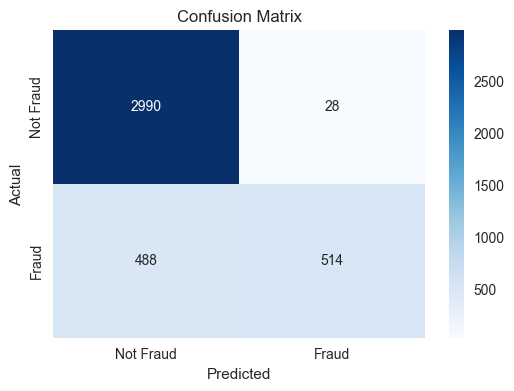

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Use the correct model from the results
best_model = results_df.iloc[0]['Best_Model']
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


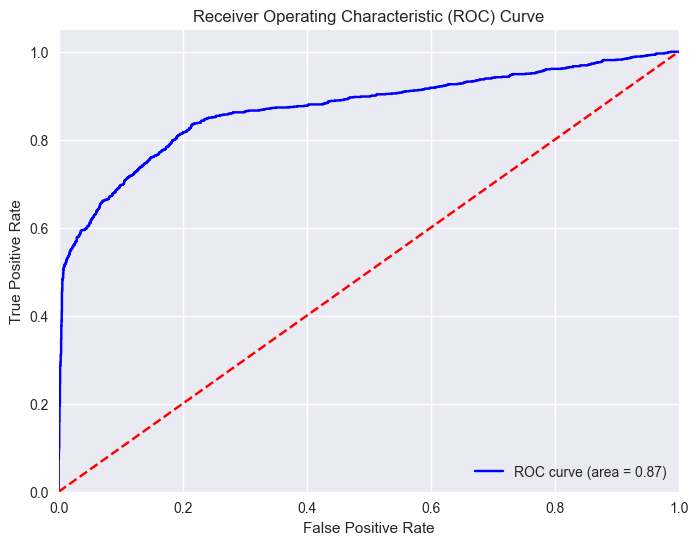

In [34]:
## Calculate ROC 
from sklearn.metrics import roc_curve, auc
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


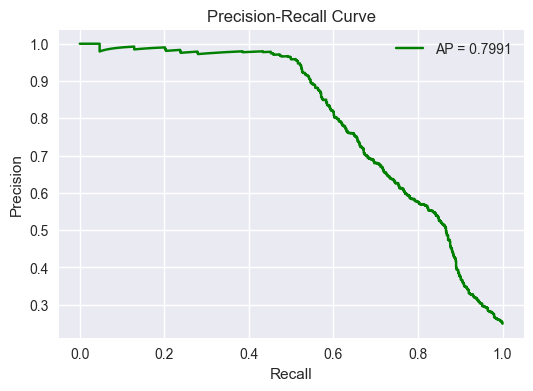

In [35]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


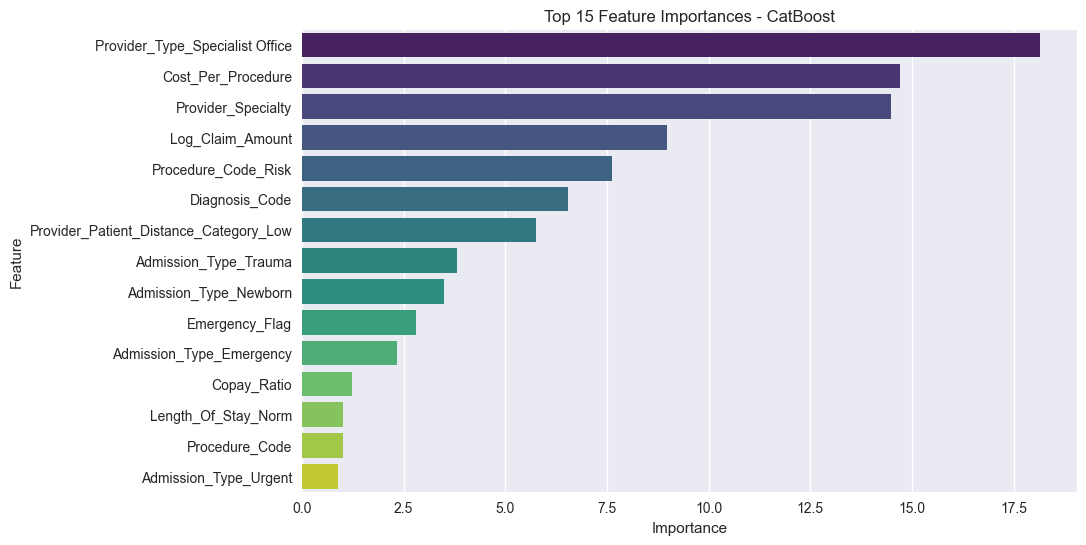

In [37]:
# Get the best model from results
best_model = results_df.iloc[0]['Best_Model']

# Extract feature importances from CatBoost model
importances = best_model.named_steps['model'].get_feature_importance()
features = X.columns

# Create feature importance dataframe
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(15), palette='viridis')
plt.title('Top 15 Feature Importances - CatBoost')
plt.show()


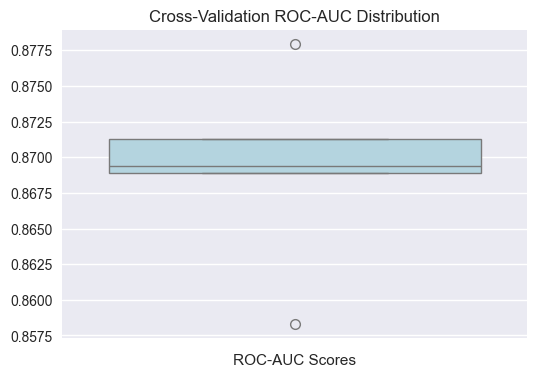

In [38]:
cv_scores = cross_val_score(best_trained_model, X_train, y_train, cv=5, scoring='roc_auc')

plt.figure(figsize=(6,4))
sns.boxplot(cv_scores, color='lightblue')
plt.title("Cross-Validation ROC-AUC Distribution")
plt.xlabel("ROC-AUC Scores")
plt.show()


## 🎯 CatBoost Model - Comprehensive Training & Evaluation

### Why CatBoost for Fraud Detection?
- **Superior Categorical Handling**: Built-in categorical encoding without preprocessing
- **Gradient Boosting**: Advanced ensemble method with excellent performance
- **Overfitting Prevention**: Built-in regularization and early stopping
- **Fast Training**: Optimized for both categorical and numerical features
- **Interpretability**: Feature importance and SHAP value support

In [39]:
# 🚀 Comprehensive CatBoost Training Pipeline
print("🎯 Starting CatBoost-focused fraud detection training...")

# Prepare data specifically for CatBoost
print("📊 Preparing data for CatBoost training...")

# Features and target
X = df_cleaned.drop(columns=['Is_Fraudulent'])
y = df_cleaned['Is_Fraudulent']

print(f"📈 Dataset prepared:")
print(f"  • Features: {X.shape[1]}")
print(f"  • Samples: {X.shape[0]:,}")
print(f"  • Fraud rate: {y.mean() * 100:.1f}%")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"✅ Train/Test split completed:")
print(f"  • Training samples: {X_train.shape[0]:,}")
print(f"  • Test samples: {X_test.shape[0]:,}")
print(f"  • Training fraud rate: {y_train.mean() * 100:.1f}%")
print(f"  • Test fraud rate: {y_test.mean() * 100:.1f}%")

🎯 Starting CatBoost-focused fraud detection training...
📊 Preparing data for CatBoost training...
📈 Dataset prepared:
  • Features: 135
  • Samples: 20,100
  • Fraud rate: 24.9%
✅ Train/Test split completed:
  • Training samples: 16,080
  • Test samples: 4,020
  • Training fraud rate: 24.9%
  • Test fraud rate: 24.9%


In [42]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from catboost import CatBoostClassifier

print("⚡ Optimized CatBoost Hyperparameter Tuning Started...")

# Reduced parameter space
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [3, 5]
}

# Initialize CatBoost with GPU support if available
catboost_model = CatBoostClassifier(
    random_state=42,
    verbose=0,
    eval_metric='AUC',
    early_stopping_rounds=30,
    task_type='CPU'    # ✅ Force CPU, avoiding GPU CUDA errors
)

# Randomized search with fewer iterations
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=10,  # Try only 10 random combinations
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("⏳ Running RandomizedSearchCV...")
random_search.fit(X_train, y_train)

best_catboost = random_search.best_estimator_
best_params = random_search.best_params_
best_cv_score = random_search.best_score_

print(f"✅ Tuning Completed! Best CV ROC-AUC: {best_cv_score:.4f}")
print(f"🎯 Optimal Parameters: {best_params}")

# Predictions
y_pred = best_catboost.predict(X_test)
y_proba = best_catboost.predict_proba(X_test)[:, 1]
print(f"📊 Predictions generated for {len(y_test)} samples")


⚡ Optimized CatBoost Hyperparameter Tuning Started...
⏳ Running RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Tuning Completed! Best CV ROC-AUC: 0.8706
🎯 Optimal Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 6}
📊 Predictions generated for 4020 samples


In [43]:
# 📊 Comprehensive Model Evaluation
print("📊 Calculating comprehensive evaluation metrics...")

# Calculate detailed metrics
from sklearn.metrics import classification_report, confusion_matrix

# Basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

# Confusion matrix components
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Advanced metrics
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # Same as recall
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
balanced_accuracy = (sensitivity + specificity) / 2

# Create comprehensive metrics dictionary
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall (Sensitivity)': recall,
    'Specificity': specificity,
    'F1-Score': f1,
    'ROC-AUC': roc_auc,
    'PR-AUC': pr_auc,
    'Balanced Accuracy': balanced_accuracy,
    'False Positive Rate': false_positive_rate,
    'False Negative Rate': false_negative_rate,
    'True Positives': tp,
    'True Negatives': tn,
    'False Positives': fp,
    'False Negatives': fn
}

# Print comprehensive results
print("\n" + "="*60)
print("🎯 CATBOOST MODEL PERFORMANCE SUMMARY")
print("="*60)

print(f"📊 Overall Performance:")
print(f"   Accuracy:           {accuracy:.4f}")
print(f"   Balanced Accuracy:  {balanced_accuracy:.4f}")
print(f"   ROC-AUC:           {roc_auc:.4f}")
print(f"   PR-AUC:            {pr_auc:.4f}")

print(f"\n🎯 Classification Metrics:")
print(f"   Precision:         {precision:.4f}")
print(f"   Recall (Sensitivity): {recall:.4f}")
print(f"   Specificity:       {specificity:.4f}")
print(f"   F1-Score:          {f1:.4f}")

print(f"\n📈 Confusion Matrix Breakdown:")
print(f"   True Positives:    {tp}")
print(f"   True Negatives:    {tn}")
print(f"   False Positives:   {fp}")
print(f"   False Negatives:   {fn}")

print(f"\n🔍 Error Analysis:")
print(f"   False Positive Rate: {false_positive_rate:.4f}")
print(f"   False Negative Rate: {false_negative_rate:.4f}")

# Performance interpretation
if roc_auc >= 0.9:
    performance = "Excellent"
elif roc_auc >= 0.8:
    performance = "Good"
elif roc_auc >= 0.7:
    performance = "Fair"
else:
    performance = "Poor"

print(f"\n✅ Overall Assessment: {performance} (ROC-AUC: {roc_auc:.3f})")
print("="*60)

# Classification Report
print(f"\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

📊 Calculating comprehensive evaluation metrics...

🎯 CATBOOST MODEL PERFORMANCE SUMMARY
📊 Overall Performance:
   Accuracy:           0.8729
   Balanced Accuracy:  0.7550
   ROC-AUC:           0.8714
   PR-AUC:            0.8024

🎯 Classification Metrics:
   Precision:         0.9456
   Recall (Sensitivity): 0.5200
   Specificity:       0.9901
   F1-Score:          0.6710

📈 Confusion Matrix Breakdown:
   True Positives:    521
   True Negatives:    2988
   False Positives:   30
   False Negatives:   481

🔍 Error Analysis:
   False Positive Rate: 0.0099
   False Negative Rate: 0.4800

✅ Overall Assessment: Good (ROC-AUC: 0.871)

📋 Detailed Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.86      0.99      0.92      3018
       Fraud       0.95      0.52      0.67      1002

    accuracy                           0.87      4020
   macro avg       0.90      0.76      0.80      4020
weighted avg       0.88      0.87      0.86      4020



🎨 Creating comprehensive performance visualizations...


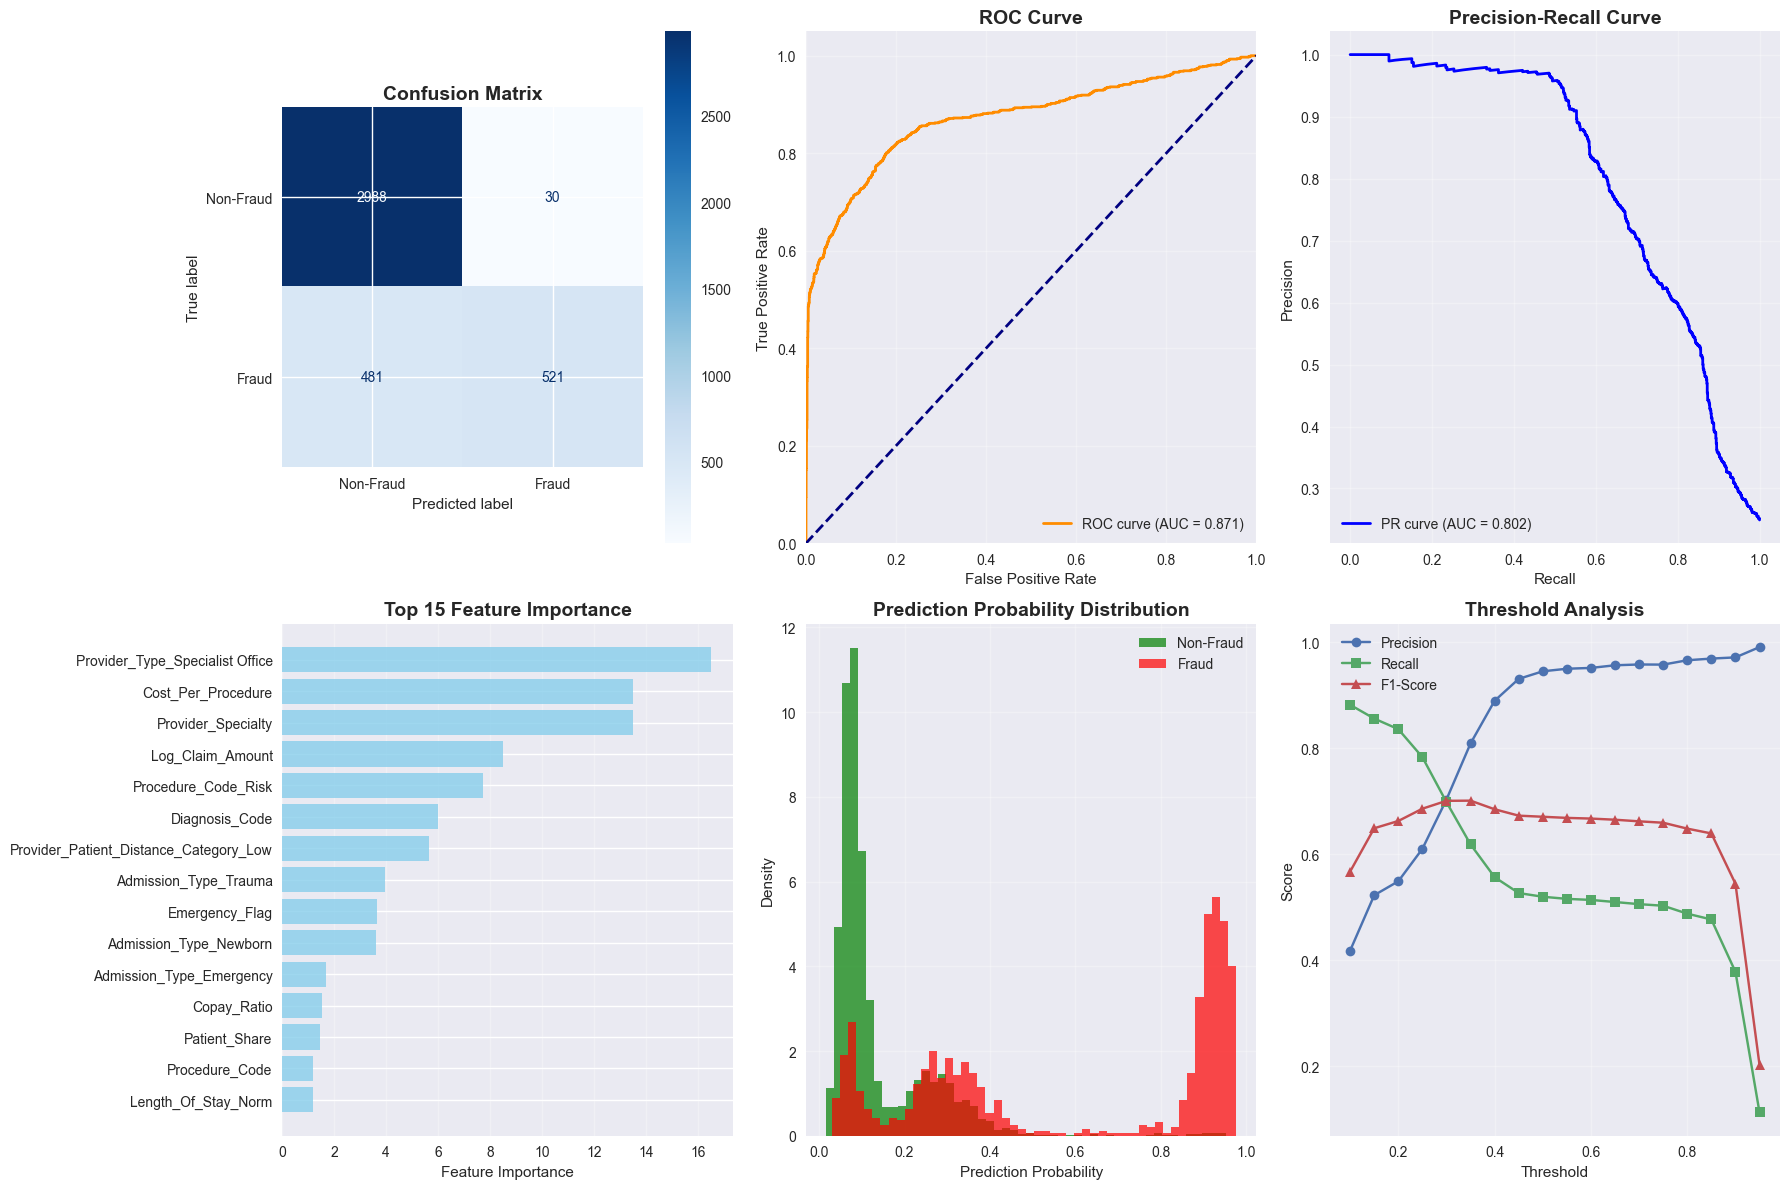

✅ Performance visualizations created and saved to '../plots/catboost_model_evaluation.png'

🔍 Top 10 Most Important Features:
   1. Provider_Type_Specialist Office: 16.5235
   2. Cost_Per_Procedure: 13.5216
   3. Provider_Specialty: 13.5173
   4. Log_Claim_Amount: 8.4893
   5. Procedure_Code_Risk: 7.7480
   6. Diagnosis_Code: 6.0059
   7. Provider_Patient_Distance_Category_Low: 5.6435
   8. Admission_Type_Trauma: 3.9671
   9. Emergency_Flag: 3.6520
  10. Admission_Type_Newborn: 3.6167
💾 Feature importance saved to '../data/feature_importance.csv'


In [44]:
# 📈 Model Performance Visualizations
print("🎨 Creating comprehensive performance visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                                   display_labels=['Non-Fraud', 'Fraud'],
                                                   cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, 
               label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
axes[0,2].plot(recall_vals, precision_vals, color='blue', lw=2,
               label=f'PR curve (AUC = {pr_auc:.3f})')
axes[0,2].set_xlabel('Recall')
axes[0,2].set_ylabel('Precision')
axes[0,2].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0,2].legend(loc="lower left")
axes[0,2].grid(True, alpha=0.3)

# 4. Feature Importance (Top 15)
feature_importance = best_catboost.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(15)

axes[1,0].barh(importance_df['feature'][::-1], importance_df['importance'][::-1], 
               color='skyblue', alpha=0.8)
axes[1,0].set_xlabel('Feature Importance')
axes[1,0].set_title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
axes[1,0].grid(axis='x', alpha=0.3)

# 5. Prediction Distribution
axes[1,1].hist(y_proba[y_test == 0], bins=50, alpha=0.7, label='Non-Fraud', 
               color='green', density=True)
axes[1,1].hist(y_proba[y_test == 1], bins=50, alpha=0.7, label='Fraud', 
               color='red', density=True)
axes[1,1].set_xlabel('Prediction Probability')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Threshold Analysis
thresholds = np.arange(0.1, 1.0, 0.05)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_thresh))
    recall_scores.append(recall_score(y_test, y_pred_thresh))
    f1_scores.append(f1_score(y_test, y_pred_thresh))

axes[1,2].plot(thresholds, precision_scores, label='Precision', marker='o')
axes[1,2].plot(thresholds, recall_scores, label='Recall', marker='s')
axes[1,2].plot(thresholds, f1_scores, label='F1-Score', marker='^')
axes[1,2].set_xlabel('Threshold')
axes[1,2].set_ylabel('Score')
axes[1,2].set_title('Threshold Analysis', fontsize=14, fontweight='bold')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../plots/catboost_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Performance visualizations created and saved to '../plots/catboost_model_evaluation.png'")

# Feature importance analysis
print(f"\n🔍 Top 10 Most Important Features:")
for i, (feature, importance) in enumerate(importance_df.head(10).values, 1):
    print(f"  {i:2d}. {feature}: {importance:.4f}")

# Save feature importance
importance_df.to_csv('../data/feature_importance.csv', index=False)
print(f"💾 Feature importance saved to '../data/feature_importance.csv'")

In [46]:
# 💾 Model Persistence and Final Summary
print("💾 Saving trained CatBoost model...")

# Save the best model
model_path = '../models/cat_boost_model.pkl'
joblib.dump(best_catboost, model_path)

# Verify model saving
import os
if os.path.exists(model_path):
    model_size = os.path.getsize(model_path) / 1024**2  # Size in MB
    print(f"✅ Model saved successfully!")
    print(f"  • File path: {model_path}")
    print(f"  • File size: {model_size:.2f} MB")
else:
    print("❌ Model saving failed!")

# Save model metadata
model_metadata = {
    'model_type': 'CatBoost Classifier',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'best_parameters': best_params,
    'cv_score': best_cv_score,
    'test_metrics': metrics,
    'feature_count': X.shape[1],
    'training_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'class_distribution': y.value_counts().to_dict()
}

# Save metadata as JSON
import json
metadata_path = '../models/model_metadata.json'

def convert_numpy_types(obj):
    """Recursively convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (pd.Series, pd.DataFrame)):
        return obj.to_dict()
    else:
        return obj

with open(metadata_path, 'w') as f:
    metadata_serializable = convert_numpy_types(model_metadata)
    json.dump(metadata_serializable, f, indent=2)

print(f"📋 Model metadata saved to '{metadata_path}'")

# Final Summary
print("\n" + "="*80)
print("🎊 CATBOOST FRAUD DETECTION MODEL TRAINING COMPLETE!")
print("="*80)
print(f"🤖 Model Type: CatBoost Classifier")
print(f"📊 Performance: {performance} (ROC-AUC: {roc_auc:.3f})")
print(f"🎯 Best CV Score: {best_cv_score:.4f}")
print(f"📈 Test Accuracy: {accuracy:.3f}")
print(f"🔍 Test Precision: {precision:.3f}")
print(f"📉 Test Recall: {recall:.3f}")
print(f"⚖️  Test F1-Score: {f1:.3f}")

print(f"\n📁 Files Generated:")
print(f"  ✅ Model: {model_path}")
print(f"  ✅ Metadata: {metadata_path}")
print(f"  ✅ Plots: ../plots/catboost_model_evaluation.png")
print(f"  ✅ Feature Importance: ../data/feature_importance.csv")

print(f"\n🚀 Next Steps:")
print(f"  1. Use the saved model for predictions in production")
print(f"  2. Update the Streamlit app with the new model")
print(f"  3. Monitor model performance on new data")
print(f"  4. Consider retraining with more data periodically")

print("="*80)
print(f"🎯 Model ready for deployment! 🚀")
print("="*80)

💾 Saving trained CatBoost model...
✅ Model saved successfully!
  • File path: ../models/cat_boost_model.pkl
  • File size: 0.23 MB
📋 Model metadata saved to '../models/model_metadata.json'

🎊 CATBOOST FRAUD DETECTION MODEL TRAINING COMPLETE!
🤖 Model Type: CatBoost Classifier
📊 Performance: Good (ROC-AUC: 0.871)
🎯 Best CV Score: 0.8706
📈 Test Accuracy: 0.873
🔍 Test Precision: 0.946
📉 Test Recall: 0.520
⚖️  Test F1-Score: 0.671

📁 Files Generated:
  ✅ Model: ../models/cat_boost_model.pkl
  ✅ Metadata: ../models/model_metadata.json
  ✅ Plots: ../plots/catboost_model_evaluation.png
  ✅ Feature Importance: ../data/feature_importance.csv

🚀 Next Steps:
  1. Use the saved model for predictions in production
  2. Update the Streamlit app with the new model
  3. Monitor model performance on new data
  4. Consider retraining with more data periodically
🎯 Model ready for deployment! 🚀
